In [7]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transform
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
import time
import torch.nn.functional as F
import os

In [6]:
# var init
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyper-parameter and setting
image_size = 28
batch_size = 16
channel_size = 3
lr = 1e-3
num_epochs = 5
num_classes = 10

# Data pre-processing of source and target domain
tf_source = transform.Compose([
    transform.Resize(image_size),
    transform.ToTensor(),
    transform.Normalize(mean=[0.1307,],  # Normalization as MNIST setting
                        std=[0.30,],
                        )
])

tf_target = transform.Compose([
    transform.Resize(image_size),
    transform.ToTensor(),
    transform.Normalize(mean=[0.5, 0.5, 0.5],  # Normalization as default setting
                        std=[0.5, 0.5, 0.5],
                        )
])

########################################################################################
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Dataset and dataloader source & target domain (train_set)
Ds_source = datasets.MNIST(root='Dataset/mnist_dataset/', download=True, train=True, transform=tf_source)
Dl_source = DataLoader(Ds_source, batch_size, shuffle=True, num_workers=2)

# Download here: https://drive.google.com/drive/folders/14IgFgyHyJ3I8-VPzzA33sBF1w2E1mVVt?usp=sharing
# Mount and unzip from directory
from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/MNIST_M.zip' -d '/content/MNIST_M/'
# Upload directly
# !unzip './MNIST_M.zip

Ds_target = datasets.ImageFolder(root='./MNIST_M//MNIST_M/train', transform=tf_target)
Dl_target = DataLoader(Ds_target, batch_size, shuffle=True, num_workers=2)
# Ds_target_test = datasets.ImageFolder(root='./MNIST_M/test', transform=tf_target)
# Dl_target_test = DataLoader(Ds_target, batch_size, shuffle=True, num_workers=2)

def plot_graph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_src_acc"], label="Train_src_acc")
    ax1.plot(history["train_tar_acc"], label="Train_tar_acc")
    ax1.legend()
    ax1.set_title("Accuracy (Src/Tar)")

    ax2.plot(history["train_loss"], label="Train_loss")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()

Streaming output truncated to the last 5000 lines.
 extracting: /content/MNIST_M/MNIST_M/train/9/00008555.png  
 extracting: /content/MNIST_M/MNIST_M/train/9/00008558.png  
 extracting: /content/MNIST_M/MNIST_M/train/9/00008563.png  
 extracting: /content/MNIST_M/MNIST_M/train/9/00008581.png  
 extracting: /content/MNIST_M/MNIST_M/train/9/00008585.png  
 extracting: /content/MNIST_M/MNIST_M/train/9/00008586.png  
 extracting: /content/MNIST_M/MNIST_M/train/9/00008592.png  
 extracting: /content/MNIST_M/MNIST_M/train/9/00008601.png  
 extracting: /content/MNIST_M/MNIST_M/train/9/00008608.png  
 extracting: /content/MNIST_M/MNIST_M/train/9/00008620.png  
 extracting: /content/MNIST_M/MNIST_M/train/9/00008626.png  
 extracting: /content/MNIST_M/MNIST_M/train/9/00008630.png  
 extracting: /content/MNIST_M/MNIST_M/train/9/00008641.png  
 extracting: /content/MNIST_M/MNIST_M/train/9/00008654.png  
 extracting: /content/MNIST_M/MNIST_M/train/9/00008669.png  
 extracting: /content/MNIST_M/MNIS

Streaming output truncated to the last 5000 lines.
[2382/3688] class loss: 0.3978 MMD_loss: 0.2851 
[2383/3688] class loss: 0.3781 MMD_loss: 0.1968 
[2384/3688] class loss: 0.6617 MMD_loss: 0.2805 
[2385/3688] class loss: 0.3932 MMD_loss: 0.2372 
[2386/3688] class loss: 0.4507 MMD_loss: 0.2582 
[2387/3688] class loss: 0.4824 MMD_loss: 0.3025 
[2388/3688] class loss: 0.4982 MMD_loss: 0.2894 
[2389/3688] class loss: 0.6247 MMD_loss: 0.1739 
[2390/3688] class loss: 0.5619 MMD_loss: 0.2617 
[2391/3688] class loss: 0.4409 MMD_loss: 0.2565 
[2392/3688] class loss: 0.5336 MMD_loss: 0.2899 
[2393/3688] class loss: 0.5852 MMD_loss: 0.2892 
[2394/3688] class loss: 0.3826 MMD_loss: 0.2148 
[2395/3688] class loss: 0.6221 MMD_loss: 0.4160 
[2396/3688] class loss: 0.4841 MMD_loss: 0.3100 
[2397/3688] class loss: 0.7182 MMD_loss: 0.3670 
[2398/3688] class loss: 0.4840 MMD_loss: 0.2460 
[2399/3688] class loss: 0.4111 MMD_loss: 0.2428 
[2400/3688] class loss: 0.5884 MMD_loss: 0.4933 
[2401/3688] class 

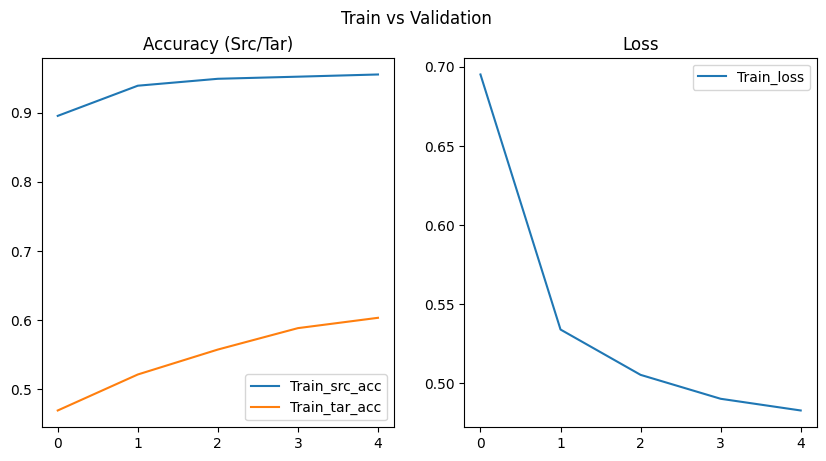

In [8]:
########################################################################################
# MMD loss
def guassian_kernel(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    n_samples = int(source.size()[0])+int(target.size()[0])
    total = torch.cat([source, target], dim=0)
    total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
    total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
    L2_distance = ((total0-total1)**2).sum(2)
    if fix_sigma:
        bandwidth = fix_sigma
    else:
        bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
    bandwidth /= kernel_mul ** (kernel_num // 2)
    bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
    kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
    return sum(kernel_val)#/len(kernel_val)

def mmdloss(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    batch_size = int(source.size()[0])
    kernels = guassian_kernel(source, target,
                              kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)
    XX = kernels[:batch_size, :batch_size]
    YY = kernels[batch_size:, batch_size:]
    XY = kernels[:batch_size, batch_size:]
    YX = kernels[batch_size:, :batch_size]
    loss = torch.mean(XX + YY - XY -YX)
    return loss

class MMDmodel(nn.Module):
    def __init__(self, n_C=10):
        super(MMDmodel, self).__init__()

        # Encoding part (green section)
        self.feature_extractor = nn.Sequential(

            nn.Conv2d(3, 64, kernel_size = 5), # 24
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),        # 12
            nn.ReLU(),

            nn.Conv2d(64, 50, kernel_size=5),  # 8
            nn.BatchNorm2d(50),
            nn.MaxPool2d(2),        # 4
            nn.ReLU(),
            nn.Dropout2d(),
        )

        # Expand from one extractor to two extractor (classed and domain-classed)
        self.num_cnn_features = 50 * 4 * 4  # 800 flattening

        # Label classification (blue section)
        self.class_classifier = nn.Sequential(

            nn.Linear(self.num_cnn_features, 100),
            nn.BatchNorm1d(100),
            nn.Dropout(),
            nn.ReLU(),

            # nn.Linear(100, 100),
            # nn.BatchNorm1d(100),
            # nn.ReLU(),

            # output logits layer (10 classes)
            nn.Linear(100, n_C),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x):

        # Handle single-channel input by expanding (repeating) the singleton dimension
        # MNIST (grayscale, 1-channel) to 3-channel
        x = x.expand(x.data.shape[0], channel_size, image_size, image_size)

        features = self.feature_extractor(x)
        features = features.view(-1, self.num_cnn_features) #Flattening
        class_prediction = self.class_classifier(features)  #regular features classification
        return  class_prediction


if __name__ == '__main__':
    lambda_mmd = 1.0
    # Computational graph
    # import torchviz
    # from torchviz import make_dot
    #
    # reverse_out = make_dot(loss, params=dict(w=w))
    # reverse_out.view()


    # network
    model = MMDmodel(n_C=num_classes).to(device)
    summary(model, input_size=(channel_size, image_size, image_size))

    # Optimizer and cost function
    optimizer = optim.Adam(model.parameters(), lr)
    # loss_fn_class = torch.nn.NLLLoss()
    # loss_fn_domain = torch.nn.NLLLoss()
    loss_fn_class = torch.nn.CrossEntropyLoss()
    loss_fn_domain = torch.nn.CrossEntropyLoss()
    # Training the same number of batches from both datasets
    max_batches = min(len(Dl_source), len(Dl_target))

    # Training
    t_0 = time.time()
    training_logs_mmd = {"train_loss": [],  "train_src_acc": [], "train_tar_acc": []}
    for epoch_idx in range(num_epochs):
        train_loss, train_src_correct, train_tar_correct = 0, 0, 0
        print(f'epochs {epoch_idx+1:04d} / {num_epochs:04d}', end='\n============\n')
        Dl_source_iter = iter(Dl_source)
        Dl_target_iter = iter(Dl_target)

        for batch_idx in range(max_batches):
        # Actually: (rely on number of data in Dataloader), for i, data in enumerate(trainloader, 0):

            # zero parameters gradient to Net and optimizer
            # model.zero_grad()
            optimizer.zero_grad()

            # Training on source domain
            X_s, y_s = next(Dl_source_iter)

            # Training on target domain
            X_t, y_t = next(Dl_target_iter)

            if X_s.shape[0] != X_t.shape[0]:
              min_bs = min(X_s.shape[0], X_t.shape[0])
              X_s = X_s[:min_bs]
              y_s = y_s[:min_bs]
              X_t = X_t[:min_bs]
              y_t = y_t[:min_bs]

            # y_s = y_s.view(batch_size)
            # y_t = y_t.view(batch_size)

            # GPU processing source and target data
            X_s, y_s = X_s.to(device), y_s.to(device)
            X_t, y_t = X_t.to(device), y_t.to(device)

            class_pred_s = model(X_s)
            class_pred_t = model(X_t)
            cls_loss = loss_fn_class(class_pred_s, y_s)                 # source classification loss

            ################### Regularizer ########################
            # Correlation alignment loss
            mmd_loss = mmdloss(class_pred_s, class_pred_t)#, kernel_mul=2.0, kernel_num=5)
            ########################################################

            # back-propagation (reversed grad to maximize domain loss)
            loss = cls_loss + lambda_mmd * mmd_loss
            loss.backward()
            # optimization tuning
            optimizer.step()

            # #output predict from net
            with torch.no_grad():
              class_prediction_s = model(X_s)
              class_prediction_t = model(X_t)

            print(f'[{batch_idx+1}/{max_batches}] '
                  f'class loss: {loss.item():.4f} '
                  f'MMD_loss: {mmd_loss.item():.4f} '
                  )
            # if batch_idx == 50:
            #     print('This is just a demo, stopping...')
            #     break

            train_loss += loss.item()
            train_src_correct += (class_prediction_s.argmax(1) == y_s).float().sum().item()
            train_tar_correct += (class_prediction_t.argmax(1) == y_t).float().sum().item()

        training_logs_mmd["train_loss"].append(train_loss / len(Dl_source))
        training_logs_mmd["train_src_acc"].append(train_src_correct / len(Dl_source.dataset))#.dataset))
        training_logs_mmd["train_tar_acc"].append(train_tar_correct / len(Dl_target.dataset))#.dataset))

        print(f'Epoch: {epoch_idx+1} || \
        Train_src_acc: {train_src_correct / len(Dl_source.dataset)}, \
        Train_tar_acc: {train_tar_correct / len(Dl_target.dataset)}, \
        Train_loss: {train_loss / len(Dl_source)}'
        )

t_end = time.time()-t_0
print(f"Time consumption for accelerated CUDA training (device:{device}): {t_end} sec")

plot_graph(training_logs_mmd)

In [9]:
# @title Function
# https://github.com/fyse-nassar/Malware-Family-Classification/blob/master/Malware%20Opcode%20Ngrams%20Generator.ipynb
# https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html

import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from typing import Optional, List
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import tqdm
import os.path as osp
import matplotlib
matplotlib.use('Agg')
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.colors as col


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    Normalization can be applied by setting `normalize=True`.
    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    #plt.xticks(tick_marks, classes, rotation=45)    #office-31
    plt.xticks(tick_marks, classes, rotation=20, fontsize=12)    #office-home
    plt.yticks(tick_marks, classes, fontsize=12)

    if normalize==True:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis]+1)
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    # print(cm)

    formated = '.2f' if normalize==True else 'd'
    #---manual---
    thresh = cm.max() / 2.
    #thresh > 0.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], formated),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #---sns---
    #df_cm = pd.DataFrame(cm, classes, classes)
    #sns.heatmap(df_cm, annot=True, fmt=formated, cmap=cmap)

    plt.gcf().set_size_inches(8, 6)
    plt.ylabel('Ground Truth')
    plt.xlabel('Prediction')
    plt.margins(2,2)
    plt.tight_layout()



"""
  Args: Collect feature
  Ref: https://github.com/zhjscut/Bridging_UDA_SSL/blob/e0be6742f1203bb983261e3e1e57d34e1e03299d/common/utils/analysis/__init__.py#L7
"""

def collect_feature(data_loader: DataLoader, feature_extractor: nn.Module,
                                   device: torch.device, max_num_features=None) -> torch.Tensor:
    """
    Fetch data from `data_loader`, and then use `feature_extractor` to collect features
    Args:
        data_loader (torch.utils.data.DataLoader): Data loader.
        feature_extractor (torch.nn.Module): A feature extractor.
        device (torch.device)
        max_num_features (int): The max number of features to return
    Returns:
        Features in shape (min(len(data_loader), max_num_features), :math:`|\mathcal{F}|`).
    """
    feature_extractor.eval()
    all_features = []
    all_labels = []
    with torch.no_grad():
        for i, (images, target) in enumerate(tqdm.tqdm(data_loader)):
            images = images.to(device)
            features = feature_extractor(images)
            if isinstance(features, tuple):
                # Check if it's a tuple (common when using certain pre-trained models)
                # You may want to select the feature tensor you need from the tuple
                # For example, if the feature tensor is the first element of the tuple:
                feature_tensor = features[0]
                feature_tensor = feature_tensor.to(device)  # Move the tensor to CPU
            else:
                feature_tensor = features.to(device)  # Move the tensor to CPU

            all_features.append(feature_tensor)
            all_labels.append(target)

    return torch.cat(all_features, dim=0),\
        torch.cat(all_labels, dim=0) # Concatenate the list of feature tensors

    #        all_features.append(features)
    #        if max_num_features is not None and i >= max_num_features:
    #            break
    #return torch.cat(all_features, dim=0)


# ref https://github.com/zhjscut/Bridging_UDA_SSL/blob/e0be6742f1203bb983261e3e1e57d34e1e03299d/common/utils/analysis/__init__.py#L7

def visualize(source_feature: torch.Tensor, target_feature: torch.Tensor,
              filename: str, source_color='r', target_color='b'):
    """
    Visualize features from different domains using t-SNE.
    Args:
        source_feature (tensor): features from source domain in shape :math:`(minibatch, F)`
        target_feature (tensor): features from target domain in shape :math:`(minibatch, F)`
        filename (str): the file name to save t-SNE
        source_color (str): the color of the source features. Default: 'r'
        target_color (str): the color of the target features. Default: 'b'
    """
    source_feature = source_feature.cpu().numpy()
    target_feature = target_feature.cpu().numpy()
    features = np.concatenate([source_feature, target_feature], axis=0)

    # map features to 2-d using TSNE
    X_tsne = TSNE(n_components=2, random_state=33).fit_transform(features)

    # domain labels, 1 represents source while 0 represents target
    domains = np.concatenate((np.ones(len(source_feature)), np.zeros(len(target_feature))))

    # visualize using matplotlib
    plt.figure(figsize=(10, 10))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=domains, cmap=col.ListedColormap([source_color, target_color]), s=20)  #default: s=2
    plt.savefig(filename)


"""
  Arg: t-SNE for class clustering visualization
"""

def visualize_class_n_domain(source_feature: torch.Tensor,
                             target_feature: torch.Tensor,
                             source_labels: torch.Tensor,
                             target_labels: torch.Tensor,
                             filename: str,
                             source_color='r',
                             target_color='b'):
    """
    Visualize features from different domains using t-SNE.
    Args:
        source_feature (tensor): features from source domain in shape :math:`(minibatch, F)`
        target_feature (tensor): features from target domain in shape :math:`(minibatch, F)`
        source_labels (tensor): class labels for source domain features
        target_labels (tensor): class labels for target domain features
        filename (str): the file name to save t-SNE
        source_color (str): the color of the source features. Default: 'r'
        target_color (str): the color of the target features. Default: 'b'
    """
    source_feature = source_feature.cpu().numpy()
    target_feature = target_feature.cpu().numpy()
    source_labels = source_labels.cpu().numpy()
    target_labels = target_labels.cpu().numpy()

    # Combine features and labels
    features = np.concatenate([source_feature, target_feature], axis=0)
    labels = np.concatenate([source_labels, target_labels], axis=0)
    domains = np.concatenate((np.ones(len(source_feature)), np.zeros(len(target_feature))))

    # Map features to 2-D using t-SNE
    X_tsne = TSNE(n_components=2, random_state=33).fit_transform(features)

    # Visualize using matplotlib
    plt.figure(figsize=(10, 10))

    # Get unique class labels
    unique_labels = np.unique(labels)

    # Create a color map for classes
    #cmap = plt.get_cmap('tab20', len(unique_labels))
    cmap_s = plt.get_cmap('nipy_spectral', len(unique_labels))
    cmap_r = plt.get_cmap('gist_rainbow', len(unique_labels))

    # Plot data points for each class and domain
    for label in unique_labels:
        for domain in [0, 1]:
            mask = (labels == label) & (domains == domain)
            plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=cmap_s(label), s=10,
                        #label=f"Class {label}, Domain {domain}",
                        )

    plt.legend()
    plt.savefig(filename)

# Example usage
# visualize(source_feature, target_feature, source_labels, target_labels, 'tsne_plot.png')





from torch.utils.data import TensorDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import SGD

"""
  Args: A-distance computation
  Ref: https://github.com/zhjscut/Bridging_UDA_SSL/blob/e0be6742f1203bb983261e3e1e57d34e1e03299d/common/utils/analysis/a_distance.py
"""

def binary_accuracy(output: torch.Tensor, target: torch.Tensor) -> float:
    """Computes the accuracy for binary classification"""
    with torch.no_grad():
        batch_size = target.size(0)
        pred = (output >= 0.5).float().t().view(-1)
        correct = pred.eq(target.view(-1)).float().sum()
        correct.mul_(100. / batch_size)
        return correct

class ANet(nn.Module):
    def __init__(self, in_feature):
        super(ANet, self).__init__()
        self.layer = nn.Linear(in_feature, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer(x)
        x = self.sigmoid(x)
        return x


def Adist_calculate(source_feature: torch.Tensor, target_feature: torch.Tensor,
              device, progress=True, training_epochs=10):
    """
    Calculate the :math:`\mathcal{A}`-distance, which is a measure for distribution discrepancy.
    The definition is :math:`dist_\mathcal{A} = 2 (1-2\epsilon)`, where :math:`\epsilon` is the
    test error of a classifier trained to discriminate the source from the target.
    Args:
        source_feature (tensor): features from source domain in shape :math:`(minibatch, F)`
        target_feature (tensor): features from target domain in shape :math:`(minibatch, F)`
        device (torch.device)
        progress (bool): if True, displays a the progress of training A-Net
        training_epochs (int): the number of epochs when training the classifier
    Returns:
        :math:`\mathcal{A}`-distance
    """
    source_label = torch.ones((source_feature.shape[0], 1))
    target_label = torch.zeros((target_feature.shape[0], 1))
    feature = torch.cat([source_feature, target_feature], dim=0)
    label = torch.cat([source_label, target_label], dim=0)

    dataset = TensorDataset(feature, label)
    length = len(dataset)
    train_size = int(0.8 * length)
    val_size = length - train_size

    # Specify a random generator for CUDA
    generator = torch.Generator(device=device)

    train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size], generator)
    train_loader = DataLoader(train_set, batch_size=2, shuffle=True, generator=generator)
    val_loader = DataLoader(val_set, batch_size=8, shuffle=False, generator=generator)

    anet = ANet(feature.shape[1]).to(device)
    optimizer = SGD(anet.parameters(), lr=0.01)
    a_distance = 2.0
    for epoch in range(training_epochs):
        anet.train()
        for (x, label) in train_loader:
            x = x.to(device)
            label = label.to(device)
            anet.zero_grad()
            y = anet(x)
            loss = F.binary_cross_entropy(y, label)
            loss.backward()
            optimizer.step()

        anet.eval()
        meter = AverageMeter("accuracy", ":4.2f")
        with torch.no_grad():
            for (x, label) in val_loader:
                x = x.to(device)
                label = label.to(device)
                y = anet(x)
                acc = binary_accuracy(y, label)
                meter.update(acc, x.shape[0])
        error = 1 - meter.avg / 100
        a_distance = 2 * (1 - 2 * error)
        if progress:
            print("epoch {} accuracy: {} A-dist: {}".format(epoch, meter.avg, a_distance))

    return a_distance




class AverageMeter(object):
    r"""Computes and stores the average and current value.
    Examples::
        >>> # Initialize a meter to record loss
        >>> losses = AverageMeter()
        >>> # Update meter after every minibatch update
        >>> losses.update(loss_value, batch_size)
    """
    def __init__(self, name: str, fmt: Optional[str] = ':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        if self.count > 0:
            self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class AverageMeterDict(object):
    def __init__(self, names: List, fmt: Optional[str] = ':f'):
        self.dict = {
            name: AverageMeter(name, fmt) for name in names
        }

    def reset(self):
        for meter in self.dict.values():
            meter.reset()

    def update(self, accuracies, n=1):
        for name, acc in accuracies.items():
            self.dict[name].update(acc, n)

    def average(self):
        return {
            name: meter.avg for name, meter in self.dict.items()
        }

    def __getitem__(self, item):
        return self.dict[item]


class Meter(object):
    """Computes and stores the current value."""
    def __init__(self, name: str, fmt: Optional[str] = ':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0

    def update(self, val):
        self.val = val

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '}'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [10]:
###########################################################################################
# --- Confusion matrix, F1-score, precision, recall, NMI/RI scores
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, normalized_mutual_info_score, adjusted_rand_score#, f1_score

# Class labels
pos_labels = np.arange(10)
lb_classes = ('0', '1', '2', '3', '4', '5', '6' ,'7', '8', '9')

# Assuming stored_lbs_tar and stored_preds_tar are tensors
# Replace these with your actual tensors if they are different
stored_lbs_tar = torch.randint(0, 10, (100,)) # Example tensor
stored_preds_tar = torch.randint(0, 10, (100,)) # Example tensor

lb = stored_lbs_tar.cpu()
prd = stored_preds_tar.cpu()
#---confusion matrix
cm_target = confusion_matrix(y_true=lb,
                            y_pred=prd,
                            labels=pos_labels,
                            normalize='true',
                            )
plt.figure()
plt.rcParams.update({'font.size': 10, 'figure.figsize': (2,2)})
plot_confusion_matrix(cm_target,
                        classes=lb_classes,
                        normalize=True,
                        title='Conf. Mat. w.r.t. CIFAR-10 ds',
                        cmap=plt.cm.binary #Blues_r
                        )    #Blues_r = off-white diagonal
#---F1-score/Precision/Recall scores
print("Precision/Recall/F-beta score:", precision_recall_fscore_support(lb, prd, average='weighted', zero_division=0,
                                          beta=1.0)) #labels=label_classes))
#---Normalized Mutual Information (NMI) score
nmi_score = normalized_mutual_info_score(labels_true=lb,
                                        labels_pred=prd,
                                        average_method='arithmetic',
                                        )
#---Rand Index (RI) score
ri_score = adjusted_rand_score(labels_true=lb,
                                labels_pred=prd,
                                )
print(f"NMI score: {nmi_score}, RI score: {ri_score}")


source_feature, s_labels = collect_feature(Dl_source, model, device)
target_feature, t_labels = collect_feature(Dl_target, model, device)

# --- Calculate A-distance, which is a measure for distribution discrepancy
A_distance = Adist_calculate(source_feature, target_feature, "cpu")
print("A-distance =", A_distance)

# --- plot t-SNE
if not os.path.exists('./output/'): os.mkdir('./output/')
tSNE_filename = osp.join('./output/', 'W5-3_tSNE.png')
visualize_class_n_domain(source_feature, target_feature, s_labels, t_labels, tSNE_filename)    # two-domain multi-class rep
print("Saving t-SNE to", tSNE_filename)

Precision/Recall/F-beta score: (0.10989818514818514, 0.1, 0.10225336067441329, None)
NMI score: 0.24124715331387295, RI score: 0.01805869074492099


100%|██████████| 3688/3688 [00:35<00:00, 103.88it/s]


epoch 0 accuracy: 90.35334777832031 A-dist: 1.6141338348388672
epoch 1 accuracy: 91.93311309814453 A-dist: 1.6773245334625244
epoch 2 accuracy: 94.59686279296875 A-dist: 1.78387451171875
epoch 3 accuracy: 92.10957336425781 A-dist: 1.6843829154968262
epoch 4 accuracy: 93.97504425048828 A-dist: 1.7590017318725586
epoch 5 accuracy: 92.53813171386719 A-dist: 1.7015252113342285
epoch 6 accuracy: 94.32797241210938 A-dist: 1.7731189727783203
epoch 7 accuracy: 92.58854675292969 A-dist: 1.7035417556762695
epoch 8 accuracy: 94.67669677734375 A-dist: 1.7870678901672363
epoch 9 accuracy: 93.8489990234375 A-dist: 1.7539598941802979
A-distance = tensor(1.7540)


<ipython-input-9-78c5ca1b2e61>:221: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=cmap_s(label), s=10,


Saving t-SNE to ./output/W5-3_tSNE.png


In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image
img = mpimg.imread("/content/output/W5-3-tSNE.png")

# Display the image
plt.imshow(img)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/content/output/W5-3-tSNE.png'